<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-исследования" data-toc-modified-id="Описание-исследования-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание исследования</a></span></li><li><span><a href="#Импорты" data-toc-modified-id="Импорты-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Подготовка-данных-и-анализ" data-toc-modified-id="Подготовка-данных-и-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных и анализ</a></span></li><li><span><a href="#Извлечение-признаков" data-toc-modified-id="Извлечение-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Извлечение признаков</a></span></li><li><span><a href="#Разбиение-на-выборки" data-toc-modified-id="Разбиение-на-выборки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Разбиение на выборки</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Boosting</a></span></li><li><span><a href="#DR-metrics" data-toc-modified-id="DR-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>DR metrics</a></span></li></ul></div>

## Описание исследования

**Цель** - определение возможности применения методов ML для прогнозирования энергопотребления промышленных предприятий для участия в [новой услуге управления спросом на розничном рынке электроэнергии](https://demand-response.ru/).

Управление спросом на электроэнергию (англ. Demand Response) — это изменение потребления электроэнергии конечными потребителями относительно их нормального профиля нагрузки (величина снижения - глубина разгрузки) в ответ на стимулирующие выплаты, предусмотренные чтобы снизить потребление в периоды высоких цен на электроэнергию на оптовом рынке.

**Проблематика** - в соответствии [с нормативной и регламентирующей услугу документацией](https://www.so-ups.ru/functioning/markets/dr/docs/) при определенный (невысокой) заявленной глубине разгрузки потребитель обязан подать планируемый график потребления на сутки вперед. Почасовое отклонение от этого графика не должно превышать 20% от заявленной глубины разгрузки - это и есть целевое значение качества модели. 

**Объект**: ЕВРАЗ Ванадий Тула (EVT) - производит оксиды феррованадия и ванадия, а именно пентоксид V2O5.

**Исходные данные** - потребление клиентов из системы "Альфа-Центр" в формате .xlsx

## Импорты

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, pandas_profiling


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, SCORERS
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

sns.set(style='whitegrid', color_codes=True, font_scale = 1.2)
pd.options.display.max_rows = 400

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

C:\ProgramData\Anaconda3\envs\praktikum_my\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Подготовка данных и анализ
Имеющиеся у нас данные представленны в не очень удобной двумерной эксель таблице.
Для начала придется преобразовать это к более привычному временному ряду

In [32]:
# что имеем
df = pd.read_excel('datasets/ЕВТ_processed.xlsx', index_col='ДД-ММ-ГГГГ')
print(df.shape)
df.tail()

(294, 24)


,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,10:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,24:00
ДД-ММ-ГГГГ,,,,,,,,,,,,,,,,,,,,,
2022-06-26,4674,4879,4309,4286,4225,4230,5053,4267,4329,4377,...,4217,4181,4197,4239,4817,4462,4237,4328,4399,4378
2022-06-27,4477,5235,4304,4163,4098,4197,5042,4359,4067,4026,...,4244,4233,4231,4160,4852,4798,4168,4232,4279,4247
2022-06-28,4341,5145,4750,4354,4141,4167,5101,4672,4338,4367,...,4304,4286,4302,4223,4914,4234,4237,4252,4342,4249
2022-06-29,4416,5390,4449,4247,4257,4250,5262,4382,4459,4452,...,4269,4347,4485,4376,5382,4243,4167,4244,4370,4407
2022-06-30,4439,5600,4633,4786,4458,4253,5331,4653,4469,4433,...,4132,4947,4406,4283,4231,4209,4178,4304,5376,4353


Основная проблема - формат datetime в python не поддерживает час 24:00 (https://github.com/astropy/astropy/issues/9837). Максимум 23:59 затем 00:00

Пришлось закостылить, либо воспользоваться [этим](https://stackoverflow.com/questions/3493924/how-can-i-convert-the-time-in-a-datetime-string-from-2400-to-0000-in-python)

В любом случае нужно уточнить, корректно ли переносить 24 час на следующие сутки

In [33]:
def alphacenter_transform(df: pd.core.frame.DataFrame):
    'преобразование двумерного массива выгрузки Альфа-центра в time series'

    # так как производятся манипуляции с индексом, строки удобнее добавлять к series, чем использовать np.array
    series_t = pd.Series()
    for i in range(len(df)):
        row = df.loc[df.index[i]]
        new_index = []    

        # цикл для часов 01-23
        for j in range(df.shape[1] - 1):
            date = df.index[i]
            time = datetime.datetime.strptime(df.columns[j],'%H:%M').time()
            date_time = datetime.datetime.combine(date, time)
            new_index.append(date_time)

        # для 24 часа прибавляем один день и записываем как 00:00 следующих суток
        date_time24 = datetime.datetime.combine(df.index[i] + datetime.timedelta(days=1), datetime.time(0, 0, 0)) 
        new_index.append(date_time24)
        row.index = new_index
        series_t = series_t.append(row)

    df_t = pd.DataFrame(series_t, columns=['values'])
    return df_t

In [4]:
df_t = alphacenter_transform(df)
df_t.info()
df_t.head(24)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 2021-09-10 01:00:00 to 2022-07-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   values  7056 non-null   int64
dtypes: int64(1)
memory usage: 110.2 KB


,values
2021-09-10 01:00:00,4417
2021-09-10 02:00:00,4440
2021-09-10 03:00:00,4431
2021-09-10 04:00:00,4472
2021-09-10 05:00:00,4435
2021-09-10 06:00:00,4388
2021-09-10 07:00:00,5224
2021-09-10 08:00:00,4387
2021-09-10 09:00:00,4518
2021-09-10 10:00:00,4622


In [5]:
# взглянем на отчет pandas_profiling
# profile = df_t.profile_report()
# profile.to_file("report.html")

In [6]:
def plotly_df(df, title = ''):
    'построение временного ряда с помощью библиотеки plotly'
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [7]:
plotly_df(df_t, 'ЕВРАЗ Ваннадий Тула')

In [8]:
df_processed = df_t[(df_t['values'] > 3000)]
plotly_df(df_processed)

Text(0.5, 1.0, 'Resid')

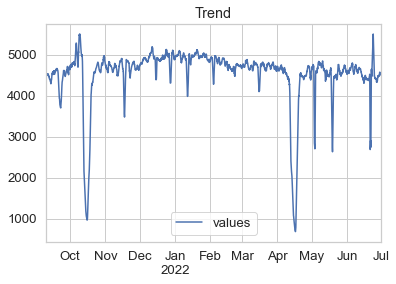

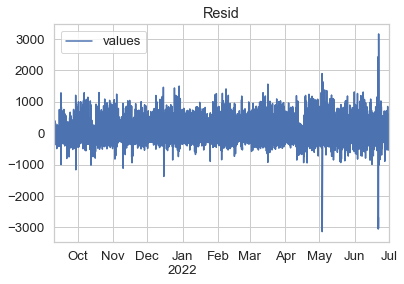

In [9]:
# посмотрим на периодическую составляющую и тренд 
decomposed = seasonal_decompose(df_t)
plotly_df(decomposed.seasonal, 'Seasonal')

decomposed.trend.plot().set_title('Trend')

decomposed.resid.plot().set_title('Resid')

## Извлечение признаков

In [10]:
def make_features(data: pd.core.frame.DataFrame, max_lag: int, rolling_mean_size: int):
    data_ext = data.copy()
    data_ext['month'] = data.index.month
    data_ext['day'] = data.index.day
    data_ext['dayofweek'] = data.index.dayofweek
    data_ext['is_weekend'] = np.ones(shape=data.shape) 

#     интересная запись, я ее взял из интернета. False*1 = 0, True*1 = 1
#     день недели считается с 0
    data_ext['is_weekend'] = data.index.dayofweek.isin([5,6])*1
    
    data_ext['hour'] = data.index.hour
     
    for lag in range(1, max_lag + 1):
        data_ext[f'lag_{lag}'] = data['values'].shift(lag)
        
    data_ext['rolling_mean'] = data['values'].shift().rolling(rolling_mean_size).mean()
    
    data_ext['seasonal'] = seasonal_decompose(data).seasonal
    data_ext['trend'] = seasonal_decompose(data).trend
    
#     сразу удалим пропуски, появившиеся из за shift(lag)
    data_ext = data_ext.dropna() 
    
    return data_ext

In [11]:
df_ext = make_features(df_t, 48, 5)
print(df_processed.shape)
print(df_ext.shape)
df_ext.head()


(6707, 1)
(6996, 57)


,values,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal,trend
2021-09-12 01:00:00,4456,9,12,6,1,1,4553.0,4445.0,4401.0,4340.0,...,5224.0,4388.0,4435.0,4472.0,4431.0,4440.0,4417.0,4461.0,65.368378,4499.333333
2021-09-12 02:00:00,4452,9,12,6,1,2,4456.0,4553.0,4445.0,4401.0,...,4387.0,5224.0,4388.0,4435.0,4472.0,4431.0,4440.0,4439.0,197.084960,4492.833333
2021-09-12 03:00:00,4414,9,12,6,1,3,4452.0,4456.0,4553.0,4445.0,...,4518.0,4387.0,5224.0,4388.0,4435.0,4472.0,4431.0,4461.4,75.372574,4490.208333
2021-09-12 04:00:00,4421,9,12,6,1,4,4414.0,4452.0,4456.0,4553.0,...,4622.0,4518.0,4387.0,5224.0,4388.0,4435.0,4472.0,4464.0,-142.149042,4486.395833
2021-09-12 05:00:00,4438,9,12,6,1,5,4421.0,4414.0,4452.0,4456.0,...,4564.0,4622.0,4518.0,4387.0,5224.0,4388.0,4435.0,4459.2,-166.052199,4479.375000


## Разбиение на выборки

In [12]:
features = df_ext.drop('values', axis = 1)
target = df_ext['values']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.115, shuffle=False)
print(features_train.shape)
features_test.shape


(6191, 56)


(805, 56)

In [13]:
features_train

,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal,trend
2021-09-12 01:00:00,9,12,6,1,1,4553.0,4445.0,4401.0,4340.0,4566.0,...,5224.0,4388.0,4435.0,4472.0,4431.0,4440.0,4417.0,4461.0,65.368378,4499.333333
2021-09-12 02:00:00,9,12,6,1,2,4456.0,4553.0,4445.0,4401.0,4340.0,...,4387.0,5224.0,4388.0,4435.0,4472.0,4431.0,4440.0,4439.0,197.084960,4492.833333
2021-09-12 03:00:00,9,12,6,1,3,4452.0,4456.0,4553.0,4445.0,4401.0,...,4518.0,4387.0,5224.0,4388.0,4435.0,4472.0,4431.0,4461.4,75.372574,4490.208333
2021-09-12 04:00:00,9,12,6,1,4,4414.0,4452.0,4456.0,4553.0,4445.0,...,4622.0,4518.0,4387.0,5224.0,4388.0,4435.0,4472.0,4464.0,-142.149042,4486.395833
2021-09-12 05:00:00,9,12,6,1,5,4421.0,4414.0,4452.0,4456.0,4553.0,...,4564.0,4622.0,4518.0,4387.0,5224.0,4388.0,4435.0,4459.2,-166.052199,4479.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27 19:00:00,5,27,4,0,19,4626.0,4359.0,4355.0,4368.0,4696.0,...,4450.0,4430.0,4422.0,5233.0,3725.0,4232.0,4690.0,4480.8,181.924906,4545.000000
2022-05-27 20:00:00,5,27,4,0,20,5624.0,4626.0,4359.0,4355.0,4368.0,...,5058.0,4450.0,4430.0,4422.0,5233.0,3725.0,4232.0,4666.4,-122.156223,4549.125000
2022-05-27 21:00:00,5,27,4,0,21,4289.0,5624.0,4626.0,4359.0,4355.0,...,4669.0,5058.0,4450.0,4430.0,4422.0,5233.0,3725.0,4650.6,-220.485646,4547.666667
2022-05-27 22:00:00,5,27,4,0,22,3708.0,4289.0,5624.0,4626.0,4359.0,...,4632.0,4669.0,5058.0,4450.0,4430.0,4422.0,5233.0,4521.2,76.210458,4545.625000


In [14]:
# обучим StandardScaler() на обучающей выборке
numeric = list(set(features_train.columns) - set(['is_weekend']))
# day', 'month', 'dayofweek', 'hour', 
scaler = StandardScaler().fit(features_train[numeric])

# если задать без индексации features_train на прямую потеряется структура pandas
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head(5))
features_test.head(5)

,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal,trend
2021-09-12 01:00:00,0.679376,-0.450886,1.504284,1,-1.517346,0.017140,-0.112059,-0.164832,-0.237807,0.032732,...,0.820161,-0.180528,-0.124228,-0.079898,-0.128861,-0.118085,-0.145616,-0.102265,0.322162,-0.053818
2021-09-12 02:00:00,0.679376,-0.450886,1.504284,1,-1.372862,-0.098877,0.017115,-0.112201,-0.164842,-0.237635,...,-0.181788,0.820225,-0.180490,-0.124190,-0.079779,-0.128859,-0.118082,-0.131211,0.971464,-0.062692
2021-09-12 03:00:00,0.679376,-0.450886,1.504284,1,-1.228379,-0.103661,-0.098902,0.016983,-0.112211,-0.164660,...,-0.024971,-0.181725,0.820262,-0.180452,-0.124072,-0.079777,-0.128856,-0.101738,0.371478,-0.066276
2021-09-12 04:00:00,0.679376,-0.450886,1.504284,1,-1.083895,-0.149111,-0.103686,-0.099044,0.016973,-0.112022,...,0.099524,-0.024909,-0.181687,0.820302,-0.180336,-0.124070,-0.079775,-0.098317,-0.700803,-0.071480
2021-09-12 05:00:00,0.679376,-0.450886,1.504284,1,-0.939412,-0.140738,-0.149136,-0.103828,-0.099054,0.017179,...,0.030094,0.099587,-0.024871,-0.181649,0.820447,-0.180334,-0.124068,-0.104633,-0.818635,-0.081065


,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean,seasonal,trend
2022-05-28 00:00:00,-0.316367,1.408213,1.004229,1,-1.661829,-0.175424,-0.266349,-0.993760,-0.298810,1.298429,...,-0.245232,0.206126,0.111596,0.155926,0.621727,-0.106114,-0.130053,-0.095949,-0.458621,0.035600
2022-05-28 01:00:00,-0.316367,1.408213,1.004229,1,-1.517346,-0.108445,-0.175449,-0.266504,-0.993773,-0.298647,...,1.012890,-0.245170,0.206164,0.111634,0.156051,0.621729,-0.106111,-0.405417,0.322162,0.047317
2022-05-28 02:00:00,-0.316367,1.408213,1.004229,1,-1.372862,0.861549,-0.108470,-0.175597,-0.266514,-0.993703,...,-0.270371,1.012953,-0.245132,0.206203,0.111758,0.156053,0.621731,-0.150159,0.971464,0.050929
2022-05-28 03:00:00,-0.316367,1.408213,1.004229,1,-1.228379,0.328112,0.861528,-0.108613,-0.175607,-0.266346,...,-0.260794,-0.270309,1.012991,-0.245094,0.206330,0.111760,0.156056,0.140626,0.371478,0.046976
2022-05-28 04:00:00,-0.316367,1.408213,1.004229,1,-1.083895,-0.027114,0.328089,0.861461,-0.108623,-0.175427,...,-0.459508,-0.260732,-0.270271,1.013031,-0.244980,0.206332,0.111763,0.193257,-0.700803,0.048427


Почему то масштабирование в данном случае не влияет на качество линейной регрессии

In [15]:
# из тестовой выборки возьмем один день
prediction_date = '2022-06-28'
features_test_day = df_ext[prediction_date].drop('values', axis = 1)
target_test_day = df_ext[prediction_date]['values']

In [16]:
# создадим функцию для вывода основных метрик качества моделей регрессии
def regression_metrics(target, predictions):
    print(f'RMSE: {np.sqrt(mean_squared_error(target, predictions)):.2f}')
    print(f'MSE:  {mean_squared_error(target, predictions):.2f}')
    print(f'R2:   {r2_score(target, predictions):.4f}')
    print(f'MAE:  {mean_absolute_error(target, predictions):.2f}')
    print(f'MAPE: {mean_absolute_percentage_error(target, predictions):.3f}')
    print('_'*20)

## Linear Regression

In [17]:
model_lr = LinearRegression().fit(features_train, target_train)

tscv = TimeSeriesSplit(n_splits=5) 
cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

-294.85490100220585

In [18]:
def predictions_plot(model, features, target, title=''):
    predictions = model.predict(features)
    plt.figure(figsize=(15, 7))
    plt.plot(predictions, "r", label="prediction")
    plt.plot(target.values, label="actual", alpha=0.5)
    plt.legend(loc="best")
    plt.title(title, fontsize=18)
    prediction_period = str(features.index.date.min()) + ' to ' +str(features.index.date.max())
    plt.title(
        f'{title}\nMAPE: {mean_absolute_percentage_error(target, predictions):.3f}\n\
        Prediction period: {prediction_period}')    

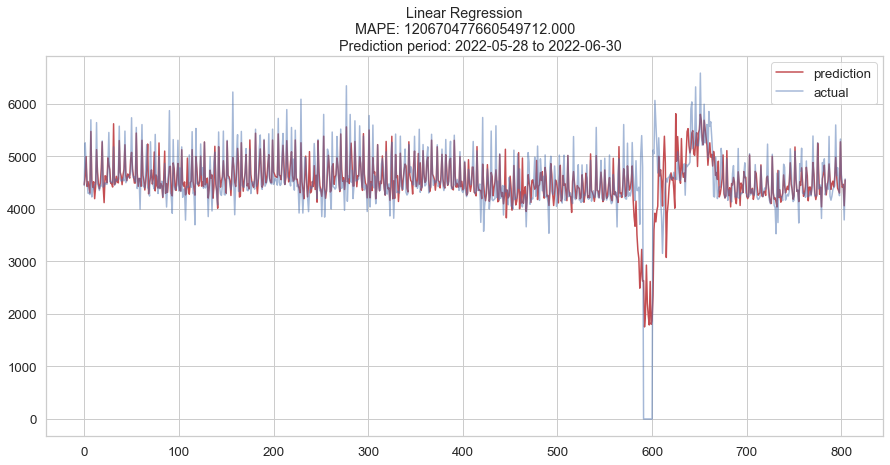

In [19]:
predictions_plot(model_lr, features_test, target_test, 'Linear Regression')

In [20]:
regression_metrics(target_test, model_lr.predict(features_test))

RMSE: 453.98
MSE:  206101.43
R2:   0.5591
MAE:  267.83
MAPE: 120670477660549712.000
____________________


## Random Forest

In [21]:
%%time 
model_rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(features_train, target_train)

Wall time: 29.9 s


In [22]:
%%time 
cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

Wall time: 1min 8s


-286.2703287609748

<AxesSubplot:>

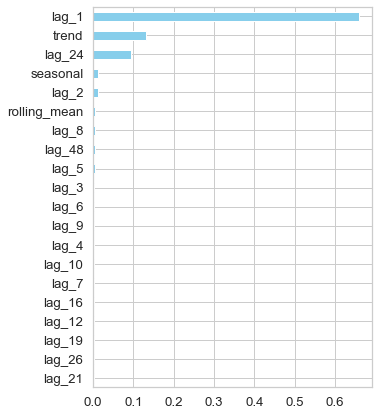

In [23]:
feat_imp = pd.Series(model_rf.feature_importances_, index=features_train.columns).nlargest(20).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(5,7), color='skyblue')

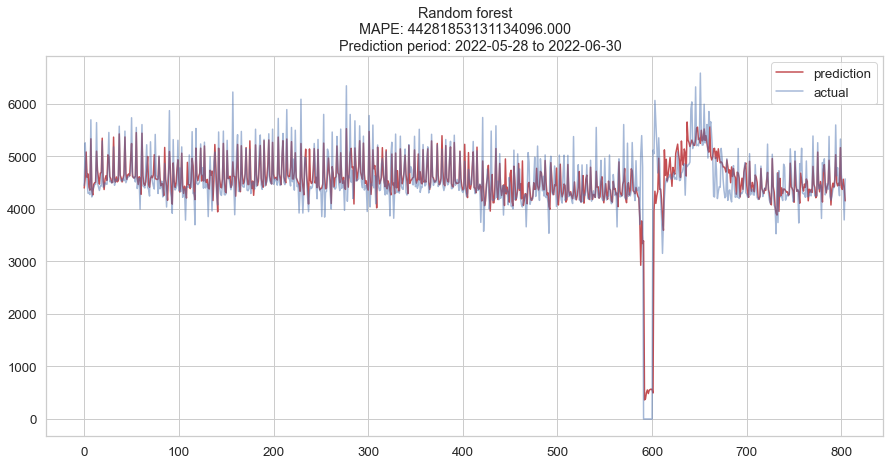

In [24]:
predictions_plot(model_rf, features_test, target_test, 'Random forest')

In [25]:
regression_metrics(target_test, model_rf.predict(features_test))

RMSE: 403.40
MSE:  162733.49
R2:   0.6519
MAE:  247.63
MAPE: 44281853131134096.000
____________________


## Boosting

In [26]:
%%time
model_lgbmr = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=RANDOM_STATE)
model_lgbmr.fit(features_train, target_train)

Wall time: 5.02 s


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=12345)

In [27]:
%%time
cross_val_score(model_lgbmr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv).mean()

Wall time: 19.5 s


-281.49980794284187

<AxesSubplot:>

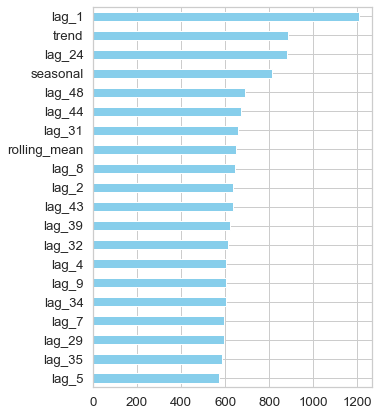

In [28]:
feat_imp = pd.Series(model_lgbmr.feature_importances_, index=features_train.columns).nlargest(20).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(5,7), color='skyblue')

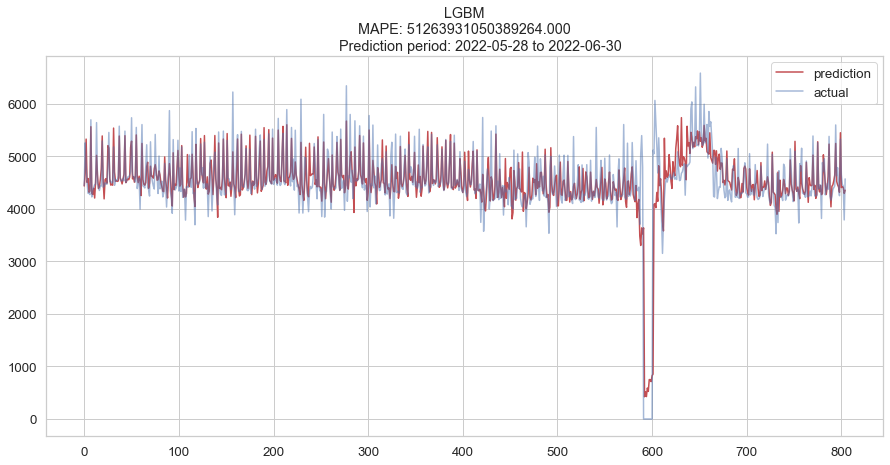

In [29]:
predictions_plot(model_lgbmr, features_test, target_test, 'LGBM')

In [30]:
regression_metrics(target_test, model_lgbmr.predict(features_test))

RMSE: 390.71
MSE:  152658.19
R2:   0.6735
MAE:  238.80
MAPE: 51263931050389264.000
____________________


## DR metrics


In [31]:
# глубина разгрузки в кВт
dr_value = 2100
0.2 * 2100
# def dr_metric(target, predictions):

420.0